In [1]:
import re
import glob
import json
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew 
from wordcloud import WordCloud, STOPWORDS 
from graphviz import Digraph
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from heapq import nlargest
from statsmodels.distributions.empirical_distribution import ECDF
import os
os.environ["PATH"] += os.pathsep + 'C:\\graphviz\\bin'

In [2]:
def get_dist_sentiment(lista, graphs):
    dist_sentiment = dict()
    all_sentiments = list()
    for each in lista:
        aux = list()
        for item in graphs[each]:
            aux.append(graphs[each].nodes[item]['sentiment'])
            all_sentiments.append(graphs[each].nodes[item]['sentiment'])
        dist_sentiment[each] = np.array(aux)
    positives = dict()
    negatives = dict()
    for i in dist_sentiment:
        k = int(len(dist_sentiment[i])*0.5)
        if(k != 0):
            number = max(nlargest(k, dist_sentiment[i]))
        else:
            number = dist_sentiment[i][0]
        if(number >= 0):
            positives[i] = dist_sentiment[i]
        else:
            negatives[i] = dist_sentiment[i]
    return all_sentiments, dist_sentiment, positives, negatives

In [3]:
def skewness(x1, original):
    #skewness = 0 : normally distributed.
    #skewness > 0 : more weight in the left tail of the distribution.
    #skewness < 0 : more weight in the right tail of the distribution. 
    
    y1 = 1./(np.sqrt(2.*np.pi)) * np.exp( -.5*(x1)**2  ) 
    
    plt.rc('ytick', labelsize=8) 
    plt.rc('xtick', labelsize=8) 
    
    item = original.split("_")
    item = item[1].split(".")
    item = item[0]
    
    plt.axvline(x=graphs[original].nodes[item]['sentiment'], color="r")
       
    plt.plot(x1, y1, '.') 

    print( '\nSkewness for data : ', skew(y1)) 

In [59]:
def classify_dist_quotes(dist_sentiment, original, graphs):
    item = original.split("_")
    item = item[1].split(".")
    item = item[0]

    maiores = dict()
    menores = dict()
    for each in dist_sentiment:
        maiores[each] = 0
        for num in dist_sentiment[each]:
            if num > graphs[original].nodes[item]['sentiment']:
            # if num > 0:
                maiores[each] += 1

    arvores_maiores = 0          

    for each in maiores:
        maiores[each] = maiores[each]/len(dist_sentiment[each])
        if(maiores[each] >= 0.5): #se pelo menos metade da árvore for mais positiva que o original
            arvores_maiores += 1

    arvores_maiores = arvores_maiores/len(maiores)
    return arvores_maiores
    

In [25]:
celebs = glob.glob("dados\\celebs\\*.json")
science = glob.glob("dados\\science\\*.json")
beliefs = glob.glob("dados\\beliefs\\*.json")

In [27]:
graphs_c = dict()
for filename in celebs:
    DG = nx.DiGraph()
    with open(filename, 'r', encoding="utf8") as f: 
        data = json.load(f)
        for tweet in data:
            DG.add_node(tweet)
            if(data[tweet]['replie_to'] is not None):
                DG.add_node(data[tweet]['replie_to'])
                DG.add_edge(tweet,data[tweet]['replie_to'])
            for attr in data[tweet]:
                DG.node[tweet][attr] = data[tweet][attr]
    graphs_c[filename] = DG

In [28]:
graphs_s = dict()
for filename in science:
    DG = nx.DiGraph()
    with open(filename, 'r', encoding="utf8") as f: 
        data = json.load(f)
        for tweet in data:
            DG.add_node(tweet)
            if(data[tweet]['replie_to'] is not None):
                DG.add_node(data[tweet]['replie_to'])
                DG.add_edge(tweet,data[tweet]['replie_to'])
            for attr in data[tweet]:
                DG.node[tweet][attr] = data[tweet][attr]
    graphs_s[filename] = DG

In [31]:
graphs_b = dict()
for filename in beliefs:
    DG = nx.DiGraph()
    with open(filename, 'r', encoding="utf8") as f: 
        data = json.load(f)
        for tweet in data:
            DG.add_node(tweet)
            if(data[tweet]['replie_to'] is not None):
                DG.add_node(data[tweet]['replie_to'])
                DG.add_edge(tweet,data[tweet]['replie_to'])
            for attr in data[tweet]:
                DG.node[tweet][attr] = data[tweet][attr]
    graphs_b[filename] = DG

In [21]:
def plot_dist_sentiment(files, graphs, filename):
    frac_sentiments = np.empty((0,1))
    for each in files:
        arq = each.split("_")
        if len(arq) == 2:
            original = each
            arq = each.split(".")
            quotes = glob.glob(arq[0] + "_*.json")
            all_sentiments, dist_sentiment, positives, negatives = get_dist_sentiment(quotes, graphs)
            classif = classify_dist_quotes(dist_sentiment, original, graphs)
            frac_sentiments = np.append(frac_sentiments, classif)
    ecdf_sentiment = ECDF(frac_sentiments)
    _= plt.figure(figsize = (20,10))
    _= plt.plot(ecdf_sentiment.x, ecdf_sentiment.y)
    _= plt.xlabel("Fração de árvores com sentimento maior que 0")
    _= plt.ylabel("Probabilidade cumulativa")
    _= plt.savefig(filename, quality = 95, orientation='portrait')

In [53]:
replies_positives = dict()
replies_len = dict()
for each in celebs:
    arq = each.split("_")
    original = arq[1].split(".")
    if len(arq) == 2:
        with open(each, 'r', encoding="utf8") as f: 
            data = json.load(f)
            replies_positives[each] = 0
            replies_len[each] = 0
            for tweet in data:
                if data[tweet]['sentiment'] >= 0:
                    replies_positives[each] += 1
                replies_len[each] += 1
                    
frac_sentiments_c = np.empty((0,1))
for item in replies_positives:
    frac_sentiments_c = np.append(frac_sentiments_c, replies_positives[item]/replies_len[item])
    

In [54]:
replies_positives = dict()
replies_len = dict()
for each in beliefs:
    arq = each.split("_")
    original = arq[1].split(".")
    if len(arq) == 2:
        with open(each, 'r', encoding="utf8") as f: 
            data = json.load(f)
            replies_positives[each] = 0
            replies_len[each] = 0
            for tweet in data:
                if data[tweet]['sentiment'] >= 0:
                    replies_positives[each] += 1
                replies_len[each] += 1
                    
frac_sentiments_b = np.empty((0,1))
for item in replies_positives:
    frac_sentiments_b = np.append(frac_sentiments_b, replies_positives[item]/replies_len[item])
    

In [55]:
replies_positives = dict()
replies_len = dict()
for each in science:
    arq = each.split("_")
    original = arq[1].split(".")
    if len(arq) == 2:
        with open(each, 'r', encoding="utf8") as f: 
            data = json.load(f)
            replies_positives[each] = 0
            replies_len[each] = 0
            for tweet in data:
                if data[tweet]['sentiment'] >= 0:
                    replies_positives[each] += 1
                replies_len[each] += 1
                    
frac_sentiments_s = np.empty((0,1))
for item in replies_positives:
    frac_sentiments_s = np.append(frac_sentiments_s, replies_positives[item]/replies_len[item])

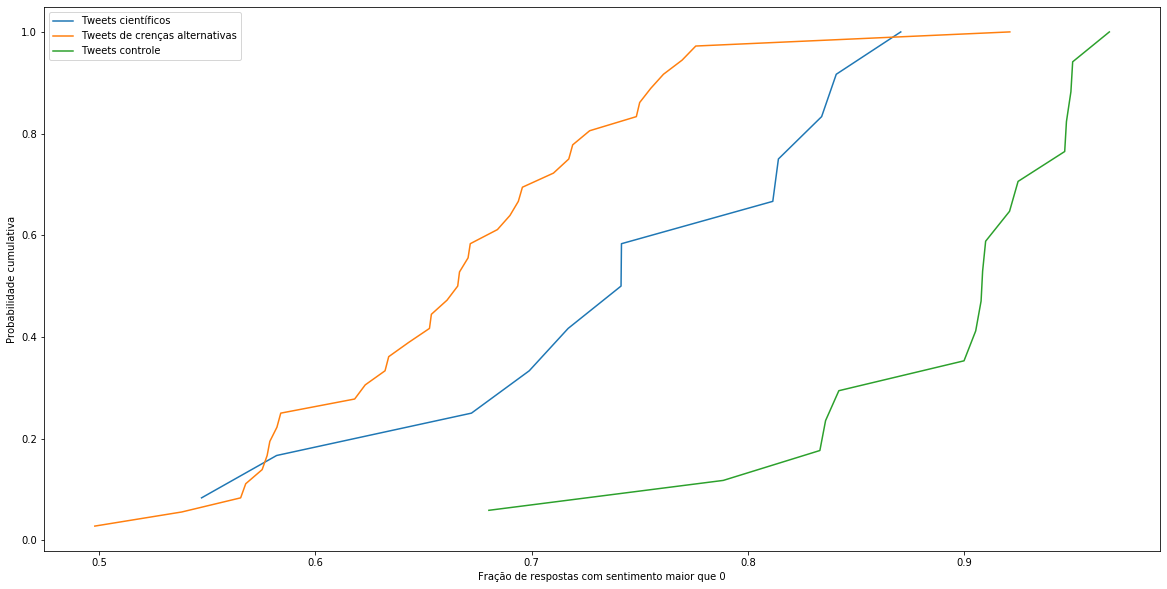

In [56]:
ecdf_c = ECDF(frac_sentiments_c)
ecdf_b = ECDF(frac_sentiments_b)    
ecdf_s = ECDF(frac_sentiments_s)

_= plt.figure(figsize = (20,10))
_= plt.plot(ecdf_s.x, ecdf_s.y, label= "Tweets científicos")
_= plt.plot(ecdf_b.x, ecdf_b.y, label= "Tweets de crenças alternativas")
_= plt.plot(ecdf_c.x, ecdf_c.y, label= "Tweets controle")
_= plt.legend()
_= plt.xlabel("Fração de respostas com sentimento maior que 0")
_= plt.ylabel("Probabilidade cumulativa")
_= plt.savefig("dist_rep_0.png", quality = 95, orientation='portrait')

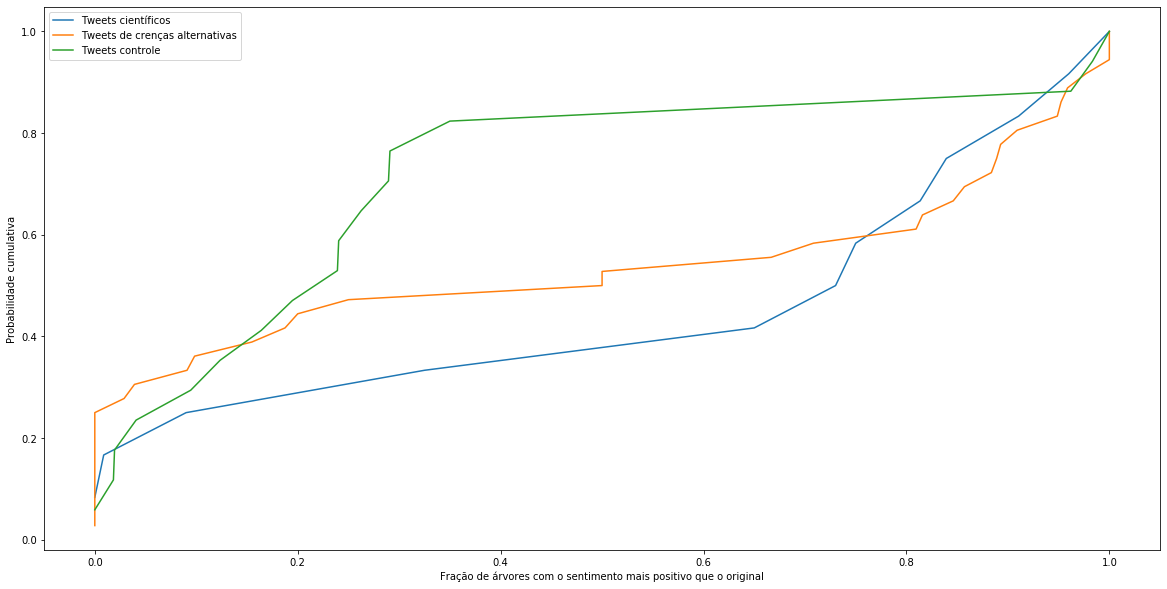

In [60]:
frac_c = np.empty((0,1))
for each in celebs:
    arq = each.split("_")
    if len(arq) == 2:
        original = each
        arq = each.split(".")
        quotes = glob.glob(arq[0] + "_*.json")
        all_sentiments, dist_sentiment, positives, negatives = get_dist_sentiment(quotes, graphs_c)
        classif = classify_dist_quotes(dist_sentiment, original, graphs_c)
        frac_c = np.append(frac_c, classif)
ecdf_c = ECDF(frac_c)
frac_b = np.empty((0,1))
for each in believes:
    arq = each.split("_")
    if len(arq) == 2:
        original = each
        arq = each.split(".")
        quotes = glob.glob(arq[0] + "_*.json")
        all_sentiments, dist_sentiment, positives, negatives = get_dist_sentiment(quotes, graphs_b)
        classif = classify_dist_quotes(dist_sentiment, original, graphs_b)
        frac_b = np.append(frac_b, classif)
ecdf_b = ECDF(frac_b)
frac_s = np.empty((0,1))
for each in science:
    arq = each.split("_")
    if len(arq) == 2:
        original = each
        arq = each.split(".")
        quotes = glob.glob(arq[0] + "_*.json")
        all_sentiments, dist_sentiment, positives, negatives = get_dist_sentiment(quotes, graphs_s)
        classif = classify_dist_quotes(dist_sentiment, original, graphs_s)
        frac_s = np.append(frac_s, classif)
ecdf_s = ECDF(frac_s)
_= plt.figure(figsize = (20,10))
_= plt.plot(ecdf_s.x, ecdf_s.y, label= "Tweets científicos")
_= plt.plot(ecdf_b.x, ecdf_b.y, label= "Tweets de crenças alternativas")
_= plt.plot(ecdf_c.x, ecdf_c.y, label= "Tweets controle")
_= plt.legend()
_= plt.xlabel("Fração de árvores com o sentimento mais positivo que o original")
_= plt.ylabel("Probabilidade cumulativa")
_= plt.savefig("dist_sent_orig.png", quality = 95, orientation='portrait')